In [1]:
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

In [2]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

from PIL import Image
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [3]:

# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True

    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df


if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(id="wallstreetbets", count=500)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)

    # Get average length over all tweets:
    #print(np.mean(df['len']))

    # Get the number of likes for the most liked tweet:
    #print(np.max(df['likes']))

    # Get the number of retweets for the most retweeted tweet:
    #print(np.max(df['retweets']))

    print(df.head(10))

    # Time Series
    #time_likes = pd.Series(data=df['len'].values, index=df['date'])
    #time_likes.plot(figsize=(16, 4), color='r')
    #plt.show()

    #time_favs = pd.Series(data=df['likes'].values, index=df['date'])
    #time_favs.plot(figsize=(16, 4), color='r')
    #plt.show()

    #time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    #time_retweets.plot(figsize=(16, 4), color='r')
    #plt.show()

    # Layered Time Series:
    #time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    #time_likes.plot(figsize=(16, 4), label="likes", legend=True)

    #time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    #time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
    #plt.show()

                                              tweets                   id  \
0  @PraveenSaragadm @Forbes @CapitalOne I can't t...  1361452480517840896   
1  @Forbes @CapitalOne literally doesn't let me p...  1361451536417710080   
2  Lots of people moved to Texas. Attracted in pa...  1361402131165683714   
3  Dear @verified here's another impersonator acc...  1361383542861815811   
4  If you have a choice between feeding your fami...  1361358258540326920   
5  @cancelwallstre1 I'm clearly no longer have an...  1361357709291962371   
6  @cancelwallstre1 You can clearly tell which ru...  1361344080748417026   
7  @APompliano Nothing beats checking on Bitcoin ...  1360832180210053120   
8  @TheAltHODLer @verasitytech When I make an esp...  1360708538012733443   
9  No DeepFuckingValue? And how much will this PP...  1360376344853442560   

   len                date               source  likes  retweets  
0  140 2021-02-15 23:09:00  Twitter for Android      1         0  
1  140 2021-02-15 

In [4]:
def cleantxt(text):
    text=re.sub(r'@[A-Za-z0-9]+','',text) #removes @metions
    text=re.sub(r'#','',text)#removes#
    text=re.sub(r'RT[\s]+','',text)#removesRT
    text=re.sub(r'https?:\/\/\S+','',text)#http hyper link
    #text=re.sub(r'b"+','',text)
    #text=re.sub(r'b''[A-Za-z0-9]+','',text)
    text=re.sub(r'[^\x00-\x7f]','',text) 
    
    return text
    

In [5]:
df['tweets']=df['tweets'].apply(cleantxt)

In [6]:
def getSubjectivity(text):
    
   return TextBlob(text).sentiment.subjectivity

In [7]:
def getPolarity(text):
    
   return TextBlob(text).sentiment.polarity

In [8]:
df['Subjectivity']=df['tweets'].apply(getSubjectivity)
df['Polarity']=df['tweets'].apply(getPolarity)

In [9]:
df["Polarity"] = pd.to_numeric(df["Polarity"], downcast="float")

In [10]:
def getanalysis(score):
    if score <0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [11]:
df['analysis']=df['Polarity'].apply(getanalysis)

In [12]:
type(df['Polarity'])
#df.head()

pandas.core.series.Series

In [35]:
j=1
sorteddf=df.sort_values(by=['Polarity'],ascending=False)



In [37]:
sorteddf.tail(50)

,tweets,id,len,date,source,likes,retweets,Subjectivity,Polarity,analysis
77,: JUST NOW on the : founder and former moderat...,1354928900699254785,140,2021-01-28 23:06:37,Twitter for Android,0,69,0.000000,0.000000,neutral
73,cc,1354933034865319938,12,2021-01-28 23:23:03,Twitter for Android,1618,50,0.000000,0.000000,neutral
65,Para los que quieren voz en Mxico,1355269749492641795,58,2021-01-29 21:41:02,Twitter for Android,447,51,0.000000,0.000000,neutral
71,So it turns out robinhood ran out of collatera...,1354997382925185024,82,2021-01-29 03:38:45,Twitter for Android,8549,1124,0.000000,0.000000,neutral
60,,1355589929930272772,23,2021-01-30 18:53:19,Twitter for Android,6233,836,0.000000,0.000000,neutral
61,It's not suspicious at all when a group of peo...,1355405906138128385,103,2021-01-30 06:42:04,Twitter for Android,2737,189,0.125000,0.000000,neutral
62,No es mala idea,1355402638704033796,31,2021-01-30 06:29:05,Twitter for Android,24,0,0.000000,0.000000,neutral
63,: I definitely think the conversation needs to...,1355359203448266752,140,2021-01-30 03:36:30,Twitter for Android,0,77,0.500000,0.000000,neutral
167,Bitcoin = Nasdaq + Dow,1347504548135411713,22,2021-01-08 11:24:54,Twitter for Android,105,10,0.000000,0.000000,neutral
66,Esa cuenta es falsa. Yo soy Jaime Rogozinski...,1355195814407266309,102,2021-01-29 16:47:15,Twitter for Android,7,0,0.000000,0.000000,neutral


In [15]:
for i in range(0,sorteddf.shape[0]):
    if (sorteddf['analysis'][i]=='negative'):
        print (str(j)+')'+sorteddf['tweets'][i],sorteddf['date'][i]) #successfully added date
        print ()
        j=j+1       

1)   I can't transfer a dime using the transfer button, wire button or any other bu  2021-02-15 23:09:00

2)  literally doesn't let me pay other people from my bank. Been making ridiculous tiny transfers e  2021-02-15 23:05:15

3) I'm clearly no longer have anything to do with the subreddit, as referenced in my previous comment. 2021-02-15 16:52:25

4)  When I make an esports tournament you'll know. Video of scrapped plans last year due to  2021-02-13 21:52:50

5)  I can't believe I just watched an 8 minute music video. It was so bad that it was ac  2021-02-11 05:52:33

6)Get a job as a trader at a Quant fund with base salary of $200k. Requirements: Spending time on WSB in lieu of a co  2021-02-11 02:26:09

7)It's like game of thrones, only real life. 2021-02-05 00:23:09

8)It seems trouble is continuing in paradise. 2021-02-05 00:13:25

9)Sounds like trouble in paradise 2021-02-04 05:29:17

10)The Hill: Biden's SEC pick sidelined as GameStop drama unfolds.
 2021-02-02 14:48:06

11)In 

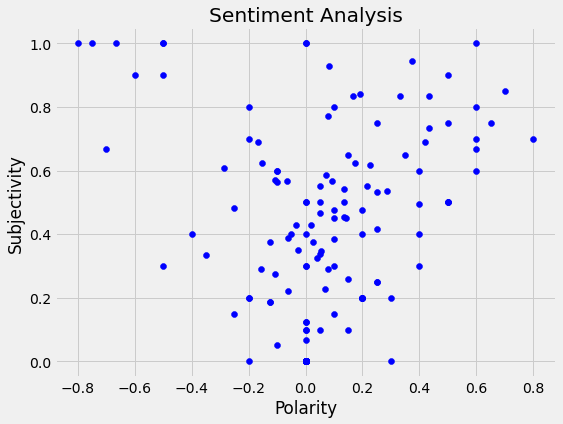

In [16]:
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i],df['Subjectivity'][i],color='Blue')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

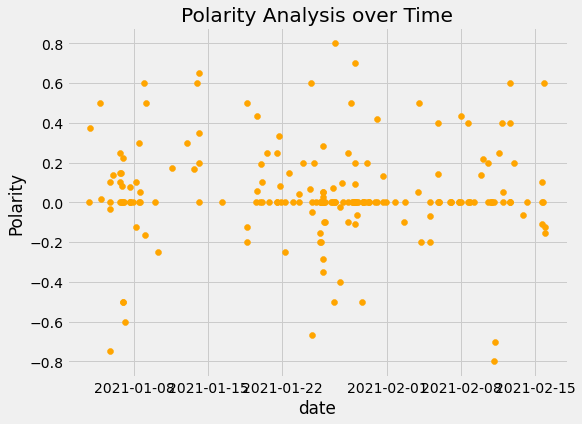

In [17]:
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['date'][i],df['Polarity'][i],color='orange')
plt.title('Polarity Analysis over Time')
plt.xlabel('date')
plt.ylabel('Polarity')
plt.show()

In [18]:
#get % of positive tweets
ptweets=df[df.analysis=='positive']
ptweets=ptweets['tweets']


In [19]:
round(ptweets.shape[0]/df.shape[0]*100,1)

35.7

In [20]:
#get % of negative tweets
ptweets=df[df.analysis=='negative']
ptweets=ptweets['tweets']


In [21]:
round(ptweets.shape[0]/df.shape[0]*100,1)

18.6

In [22]:
#get % of neutral tweets
ptweets=df[df.analysis=='neutral']
ptweets=ptweets['tweets']

In [23]:
round(ptweets.shape[0]/df.shape[0]*100,1)

45.7

In [24]:
df['analysis'].value_counts()

neutral     91
positive    71
negative    37
Name: analysis, dtype: int64

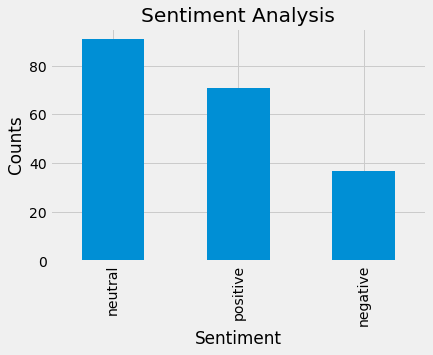

In [25]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['analysis'].value_counts().plot(kind='bar')
plt.show()

In [26]:
twitter_mask = np.array(Image.open("twitter_mask.png"))


In [27]:
allwords = " ".join(tweet for tweet in df.tweets)
print ("There are {} words in the combination of all tweets.".format(len(allwords)))

There are 14159 words in the combination of all tweets.


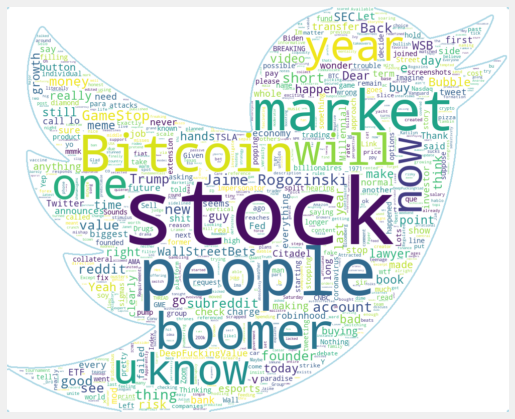

In [28]:
#set and update stopwords

stopwords = set(STOPWORDS)
stopwords.update(["American", "amp","Tune"])

# Create a word cloud image
wc = WordCloud(stopwords=stopwords,width=500, height=300,background_color="white", max_words=1000, mask=twitter_mask,
           contour_width=3, contour_color='lightblue')



# Generate a wordcloud
wc.generate(allwords)

# store to file
wc.to_file("twitter1.png")

# show
plt.figure(figsize=[8,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
#p1 = TwitterStreamer()
#p1.stream_tweets(df,'#climate')

In [30]:
# allwords